# Data Exploration

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import warnings
import os

warnings.filterwarnings('ignore')
plt.style.use('ggplot')

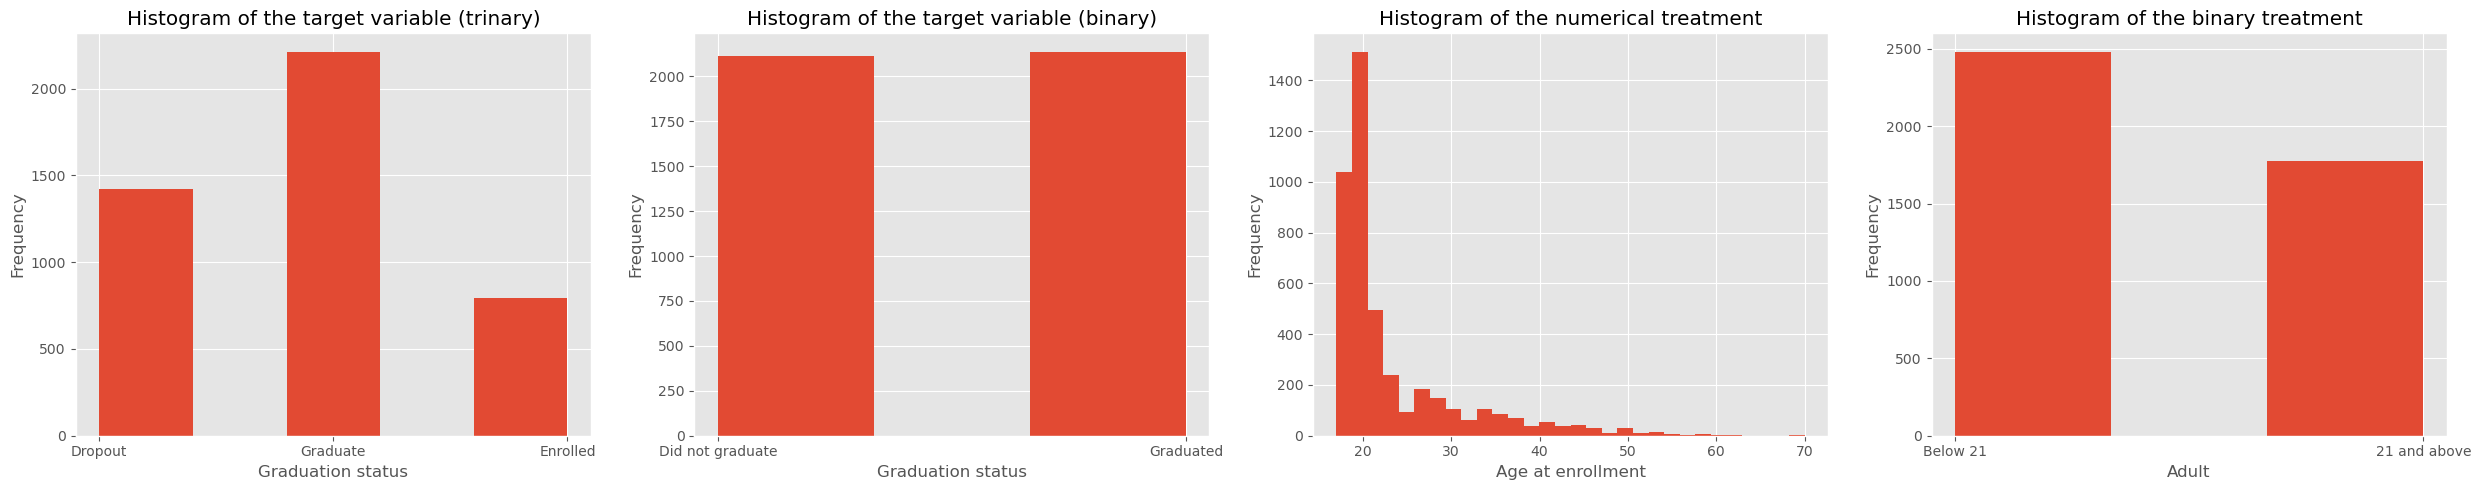

In [2]:
raw_data_df = pd.read_csv('data/raw_data.csv')
processed_data_df = pd.read_csv('data/processed_data.csv')

PREPROCESSED_TARGET_NAME = 'Target'
TARGET_VARIABLE_NAME = 'Target'
NUMERIC_TREATMENT_NAME = 'Age at enrollment'
BINARY_TREATMENT_NAME = 'Adult'

# plot 4 graphs side by side
# The first is the histogram of the target variable from the raw data
# The first is the histogram of the target variable from the processed data
# The second is the histogram of the numerical treatment from the raw data
# The third is the histogram of the binary treatment from the processed data

fig, axs = plt.subplots(1, 4, figsize=(25, 5))

plt.subplots_adjust(wspace=0.7)  # Increase this value to add more space

# plot the histogram of the target variable from the raw data
axs[0].hist(raw_data_df[TARGET_VARIABLE_NAME], bins=5)
axs[0].set_title('Histogram of the target variable (trinary)')
axs[0].set_xlabel('Graduation status')
axs[0].set_ylabel('Frequency')

# plot the histogram of the target variable from the processed data
# The category of 0 should be renamed to 'Did not graduate' and the category of 1 should be renamed to 'Graduated'
axs[1].hist(processed_data_df[TARGET_VARIABLE_NAME], bins=3)
axs[1].set_title('Histogram of the target variable (binary)')
axs[1].set_xlabel('Graduation status')
axs[1].set_ylabel('Frequency')
axs[1].set_xticks([0, 1])
axs[1].set_xticklabels(['Did not graduate', 'Graduated'])

# plot the histogram of the numerical treatment from the raw data
axs[2].hist(raw_data_df[NUMERIC_TREATMENT_NAME], bins=30)
axs[2].set_title('Histogram of the numerical treatment')
axs[2].set_xlabel('Age at enrollment')
axs[2].set_ylabel('Frequency')

# plot the histogram of the binary treatment from the processed data.
# The category of 0 should be renamed to ' Below 21' and the category of 1 should be renamed to '21 and above'
axs[3].hist(processed_data_df[BINARY_TREATMENT_NAME], bins=3)
axs[3].set_title('Histogram of the binary treatment')
axs[3].set_xlabel('Adult')
axs[3].set_ylabel('Frequency')
axs[3].set_xticks([0, 1])
axs[3].set_xticklabels(['Below 21', '21 and above'])

# save the plot
PLOTS_DIR = '/Users/gurkeinan/semester6/Causal-Inference/Project/report/plots'

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)

plt.savefig(f'{PLOTS_DIR}/target_and_treatments_histograms')

plt.tight_layout()
plt.show()

# Checking Common Support

The common support assumption states that each unit has a non-zero probability of receiving each treatment level - $\forall x \in X, P(T=1|X=x) > 0$ and $P(T=0|X=x) > 0$.

In [3]:
from estimation_methods.utils import read_and_transform_data

DATA_PATH = '/Users/gurkeinan/semester6/Causal-Inference/Project/code/data/processed_data.csv'
X, t, y = read_and_transform_data(DATA_PATH)

In [4]:
# Estimate propensity scores
propensity_model = LogisticRegression(random_state=42)
propensity_model.fit(X, t)
propensity_scores = propensity_model.predict_proba(X)[:, 1]

# Add propensity scores to the dataframe
X['propensity_score'] = propensity_scores

In [5]:
# Check common support
min_treated = X[t == 1]['propensity_score'].min()
max_treated = X[t == 1]['propensity_score'].max()
min_untreated = X[t == 0]['propensity_score'].min()
max_untreated = X[t == 0]['propensity_score'].max()

print(f"Treated group propensity score range: [{min_treated:.4f}, {max_treated:.4f}]")
print(f"Untreated group propensity score range: [{min_untreated:.4f}, {max_untreated:.4f}]")

if min_treated <= max_untreated and min_untreated <= max_treated:
    print("The common support condition appears to hold.")
else:
    print("The common support condition may not hold.")

# Calculate the overlap coefficient
overlap_min = max(min_treated, min_untreated)
overlap_max = min(max_treated, max_untreated)
overlap_coefficient = (overlap_max - overlap_min) / (max_treated - min_untreated)

print(f"Overlap coefficient: {overlap_coefficient:.4f}")

Treated group propensity score range: [0.0131, 1.0000]
Untreated group propensity score range: [0.0066, 0.9856]
The common support condition appears to hold.
Overlap coefficient: 0.9791


In [6]:
PLOTS_DIR = '/Users/gurkeinan/semester6/Causal-Inference/Project/report/plots'

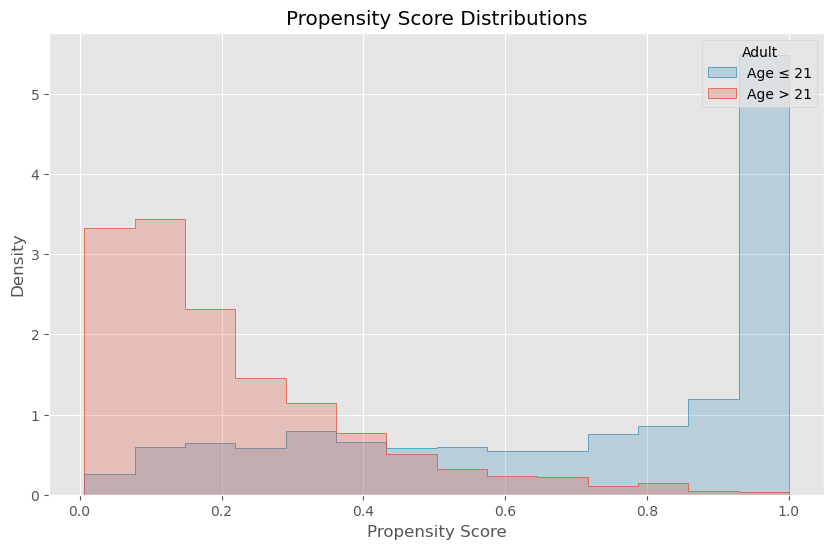

In [7]:
Xt = pd.concat([X, t], axis=1)

# Visualize propensity score distributions
plt.figure(figsize=(10, 6))

sns.histplot(data=Xt, x='propensity_score', hue='Adult',
             element='step', stat='density', common_norm=False)
plt.title('Propensity Score Distributions')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend(title='Adult', labels=['Age ≤ 21', 'Age > 21'])

# Save the plot
plt.savefig(f'{PLOTS_DIR}/propensity_score_distributions.png')

plt.show()

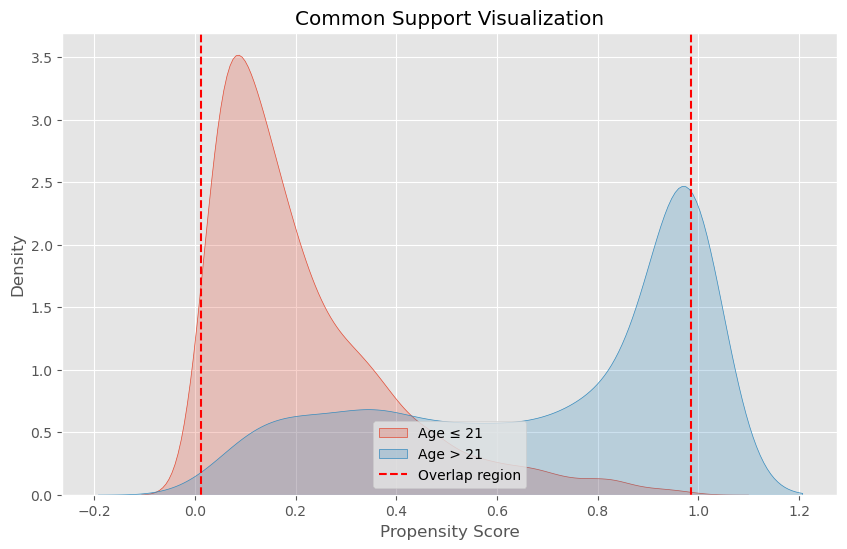

In [8]:
# Visualize common support
plt.figure(figsize=(10, 6))
sns.kdeplot(data=X[t == 0]['propensity_score'],
            label='Age ≤ 21', shade=True)
sns.kdeplot(data=X[t == 1]['propensity_score'],
            label='Age > 21', shade=True)
plt.axvline(overlap_min, color='r', linestyle='--', label='Overlap region')
plt.axvline(overlap_max, color='r', linestyle='--')
plt.title('Common Support Visualization')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.legend()

# Save the plot
plt.savefig(f'{PLOTS_DIR}/common_support.png')

plt.show()